In [1]:
%run ../src/start.py


python	3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
---------------------
Versions:
----------------------
pandas      1.1.2
numpy       1.19.1
matplotlib  3.3.1
seaborn     0.11.0
plotly      4.11.0
boto3       1.17.106
awswrangler 2.9.0
----------------------


Loaded Libraries
-------------------
import pandas as pd
import numpy as np
import sys,os
import re
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


## AWS
import boto3
import awswrangler as wr
----------------


GLOBAL VARIABLES
--------------------------
HERE_DIR: list current directory path
RAW_DIR: list files in `data\raw` directory
INTER_DIR: list files in `data\interim` directory
FINAL_DIR: list files in `data\final` directory
SRC_DIR: list files in `src\` directory
------------------------------

# SAVE PLOTS
To save a plot 

## Load Data

In [2]:
# year file
year = '2013'

In [3]:
# helper function
def bucket_raw_path(bucket_name,path_dir):
    ''''''
    raw_path = f's3://{bucket_name}/{path_dir}'
    return raw_path

In [4]:
raw = bucket_raw_path('salas-data',f'capstone/raw-data/crime-data/{year}')
raw

's3://salas-data/capstone/raw-data/crime-data/2013'

## List objects in bucket

In [5]:
wr.s3.list_objects(raw)

['s3://salas-data/capstone/raw-data/crime-data/2013/apr13.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2013/aug13.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2013/dec13.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2013/feb13.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2013/jan13.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2013/jul13.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2013/jun13.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2013/mar13.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2013/may13.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2013/nov13.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2013/oct13.xlsx',
 's3://salas-data/capstone/raw-data/crime-data/2013/sep13.xlsx']

## Create dataframe from s3 files

In [6]:
def s3_files_to_df(s3_files_path):
    ''' load s3 file path from wr result
    returns a dataframe of concat files '''
    df_list = []
    for i in wr.s3.list_objects(s3_files_path):
        temp = wr.s3.read_excel(i, engine='openpyxl')
        df_list.append(temp)
    # create df from list files
    df = pd.concat(df_list, ignore_index=True)
    return df

In [7]:
%%time
df = s3_files_to_df(raw)

CPU times: user 21.3 s, sys: 125 ms, total: 21.4 s
Wall time: 30.6 s


In [8]:
## cleanup columns
df.columns = df.columns.str.lower().str.replace(' ','_').str.replace('\n','_').str.strip()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130459 entries, 0 to 130458
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           130459 non-null  datetime64[ns]
 1   hour           130459 non-null  int64         
 2   offense_type   130459 non-null  object        
 3   beat           130459 non-null  object        
 4   premise        130459 non-null  object        
 5   block_range    130459 non-null  object        
 6   street_name    130459 non-null  object        
 7   type           130459 non-null  object        
 8   suffix         130459 non-null  object        
 9   ._of_offenses  130459 non-null  int64         
 10  field11        0 non-null       float64       
 11  field2         0 non-null       float64       
 12  field12        0 non-null       float64       
 13  field13        0 non-null       float64       
 14  field14        0 non-null       float64       
dtype

In [10]:
df.head()

,date,hour,offense_type,beat,premise,block_range,street_name,type,suffix,._of_offenses,field11,field2,field12,field13,field14
0,2013-04-25,5,Murder,19G10,13R,9400-9499,WOODFAIR,DR,-,1,NaN,NaN,NaN,NaN,NaN
1,2013-04-14,0,Murder,17E40,18A,6100-6199,BELLFORT,ST,W,1,NaN,NaN,NaN,NaN,NaN
2,2013-04-02,16,Murder,20G10,20A,9900-9999,RICHMOND,AVE,-,1,NaN,NaN,NaN,NaN,NaN
3,2013-04-19,22,Murder,2A20,13R,1300-1399,29TH,ST,E,1,NaN,NaN,NaN,NaN,NaN
4,2013-04-23,0,Murder,1A10,190,500-599,RUSK,-,-,1,NaN,NaN,NaN,NaN,NaN


## Show null data

In [11]:
df.apply(lambda x: sum(x.isnull()))

date                  0
hour                  0
offense_type          0
beat                  0
premise               0
block_range           0
street_name           0
type                  0
suffix                0
._of_offenses         0
field11          130459
field2           130459
field12          130459
field13          130459
field14          130459
dtype: int64

In [12]:
# create null percentage of column as dataframe
null_per_df = pd.DataFrame(df.isna().mean().round(4) * 100)
# rename columns
null_per_df.rename(columns={'index': 'col_name', 0: 'null_percent'}, inplace=True)

# filter data <20% null values
per_filter = null_per_df.null_percent<=90
null_per_df[per_filter].sort_values(by='null_percent',ascending=False)

,null_percent
date,0.0
hour,0.0
offense_type,0.0
beat,0.0
premise,0.0
block_range,0.0
street_name,0.0
type,0.0
suffix,0.0
._of_offenses,0.0


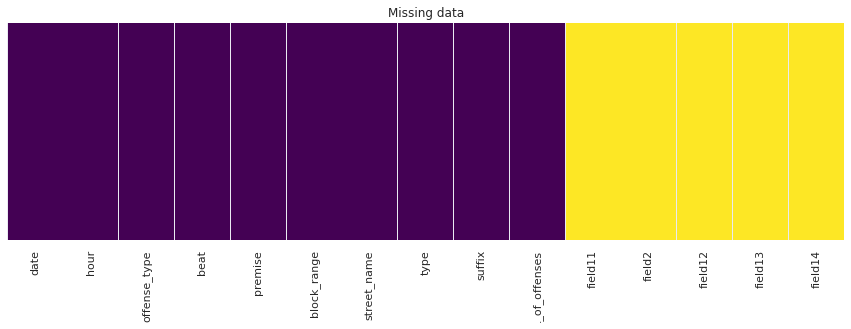

In [13]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

# Drop unused columns & change column names

In [14]:
df = df.drop([  'field11',
 'field2',
 'field12',
 'field13',
 'field14'], axis = 1)

#change column name

df.rename(columns={
    '._of_offenses': 'offenses',
}, inplace=True)

In [15]:
df.apply(lambda x: sum(x.isnull()))

date            0
hour            0
offense_type    0
beat            0
premise         0
block_range     0
street_name     0
type            0
suffix          0
offenses        0
dtype: int64

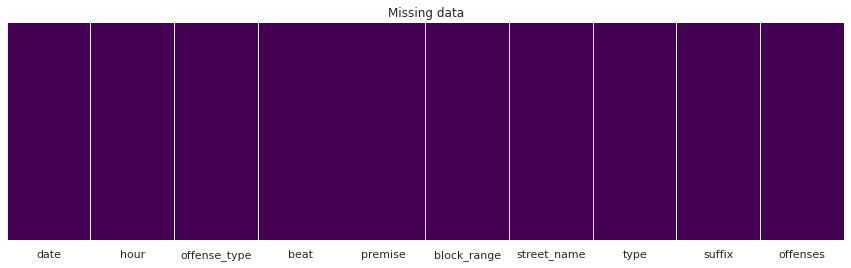

In [16]:
plt.figure(figsize=(15,4))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.title('Missing data')
plt.show()

## Combine columns 

## Combine date & hour to one column

In [17]:
# convert two columns into one datetime
df['date_time'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')

# drop columns
df = df.drop(['date','hour'], axis = 1)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130459 entries, 0 to 130458
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   offense_type  130459 non-null  object        
 1   beat          130459 non-null  object        
 2   premise       130459 non-null  object        
 3   block_range   130459 non-null  object        
 4   street_name   130459 non-null  object        
 5   type          130459 non-null  object        
 6   suffix        130459 non-null  object        
 7   offenses      130459 non-null  int64         
 8   date_time     130459 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 9.0+ MB


In [19]:
df.head()

,offense_type,beat,premise,block_range,street_name,type,suffix,offenses,date_time
0,Murder,19G10,13R,9400-9499,WOODFAIR,DR,-,1,2013-04-25 05:00:00
1,Murder,17E40,18A,6100-6199,BELLFORT,ST,W,1,2013-04-14 00:00:00
2,Murder,20G10,20A,9900-9999,RICHMOND,AVE,-,1,2013-04-02 16:00:00
3,Murder,2A20,13R,1300-1399,29TH,ST,E,1,2013-04-19 22:00:00
4,Murder,1A10,190,500-599,RUSK,-,-,1,2013-04-23 00:00:00


## Convert offenses to integer

In [20]:
# convert offenses to int
df['offenses'] = df['offenses'].astype('int64')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130459 entries, 0 to 130458
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   offense_type  130459 non-null  object        
 1   beat          130459 non-null  object        
 2   premise       130459 non-null  object        
 3   block_range   130459 non-null  object        
 4   street_name   130459 non-null  object        
 5   type          130459 non-null  object        
 6   suffix        130459 non-null  object        
 7   offenses      130459 non-null  int64         
 8   date_time     130459 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 9.0+ MB


## change order of columns

In [22]:
col_ord =['date_time','offenses','offense_type', 'block_range', 'street_name', 'type', 'suffix','beat', 'premise']
df = df[col_ord]
df.head()

,date_time,offenses,offense_type,block_range,street_name,type,suffix,beat,premise
0,2013-04-25 05:00:00,1,Murder,9400-9499,WOODFAIR,DR,-,19G10,13R
1,2013-04-14 00:00:00,1,Murder,6100-6199,BELLFORT,ST,W,17E40,18A
2,2013-04-02 16:00:00,1,Murder,9900-9999,RICHMOND,AVE,-,20G10,20A
3,2013-04-19 22:00:00,1,Murder,1300-1399,29TH,ST,E,2A20,13R
4,2013-04-23 00:00:00,1,Murder,500-599,RUSK,-,-,1A10,190


## Save to bucket

In [23]:
bucket = 'salas-data'
file_name = f'crime_{year}.csv'
path_to_save = f"s3://{bucket}/capstone/inter-data/crime-data/{file_name}"
path_to_save

's3://salas-data/capstone/inter-data/crime-data/crime_2013.csv'

In [24]:
%%time
wr.s3.to_csv(df, path_to_save, index=False)

CPU times: user 453 ms, sys: 62.5 ms, total: 516 ms
Wall time: 6.13 s


{'paths': ['s3://salas-data/capstone/inter-data/crime-data/crime_2013.csv'],
 'partitions_values': {}}